<a href="https://colab.research.google.com/github/mariajoseph83/LoadForecasting_in_Micro_Grid/blob/main/Codes/major_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays as hd

from time import time
import datetime
import random

from statsmodels.tsa.seasonal import STL

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import tensorflow as tf
from keras.layers import Input, Dense, LeakyReLU, LSTM, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model, Model
!pip install keras-tuner
import keras_tuner
from keras_tuner.tuners import BayesianOptimization

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 807.0 kB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [ ]:
# Set main working directory and secondary folder paths
directory = os.getcwd() # get working directory
data_path = '/content/drive/MyDrive/Data/'
models_path = '/content/drive/MyDrive/Model/'

In [ ]:
weather = pd.read_csv(data_path+'weather'+'.csv')

In [ ]:
weather


,time,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density
0,01-01-1980 00:00,0.1148,8.066,0.0,0.0,0.0024,0.0286,0.6981,1.1900
1,01-01-1980 01:00,0.1347,7.960,0.0,0.0,0.0044,0.0321,0.7431,1.1907
2,01-01-1980 02:00,0.1779,8.008,0.0,0.0,0.0053,0.0370,0.7766,1.1911
3,01-01-1980 03:00,0.1739,8.065,0.0,0.0,0.0167,0.0487,0.7607,1.1912
4,01-01-1980 04:00,0.1461,8.009,0.0,0.0,0.0103,0.0613,0.6991,1.1911
...,...,...,...,...,...,...,...,...,...
350635,31-12-2019 19:00,0.0001,8.295,0.0,0.0,0.0000,0.0001,0.1557,1.2029
350636,31-12-2019 20:00,0.0001,7.805,0.0,0.0,0.0000,0.0001,0.1382,1.2048
350637,31-12-2019 21:00,0.0003,7.342,0.0,0.0,0.0000,0.0001,0.1363,1.2063
350638,31-12-2019 22:00,0.0003,6.959,0.0,0.0,0.0000,0.0001,0.1233,1.2076


In [ ]:
# Read the relevant weather data from the weather.csv file
weather = pd.read_csv(data_path+'weather'+'.csv')
weather.columns = weather.iloc[1]
weather = weather.iloc[2:]
weather['date'] = pd.to_datetime(weather['time']) # convert timestamps to dates
weather = weather.loc[weather['date'] >= '2015-01-01 00:00:00'] # keep data from 2015 onwards
weather.index = weather['date'] # set the date as the index
weather = weather[['temperature', 'irradiance_surface', 'precipitation', 'cloud_cover']]

KeyError: 'time'

In [ ]:
weather.columns()

TypeError: 'Index' object is not callable

In [ ]:
# Read the relevant consumption data from the consumption.csv file
consumption = pd.read_csv(data_path+'consumption'+'.csv')
consumption['date'] = pd.to_datetime(consumption['utc_timestamp'], format='%Y-%m-%dT%H:%M:%SZ') # convert timestamps to dates
consumption.index = consumption['date'] # set the date as the index
consumption = pd.DataFrame(consumption['ES_load_actual_entsoe_transparency'][1:])
consumption.columns = ['load']

In [ ]:
# combine consumption and weather data into a single dataframe
data = pd.concat([consumption, weather], axis=1)
data

,load,temperature,irradiance_surface,precipitation,cloud_cover
date,,,,,
2015-01-01 00:00:00,NaN,3.438,0.0,0.0002,0.1066
2015-01-01 01:00:00,22734.0,3.217,0.0,0.0003,0.1254
2015-01-01 02:00:00,21286.0,3.103,0.0,0.0004,0.121
2015-01-01 03:00:00,20264.0,3.051,0.0,0.0004,0.095
2015-01-01 04:00:00,19905.0,2.982,0.0,0.0003,0.083
...,...,...,...,...,...
2019-12-31 19:00:00,29362.0,8.295,0.0,0.0001,0.1557
2019-12-31 20:00:00,27608.0,7.805,0.0,0.0001,0.1382
2019-12-31 21:00:00,25241.0,7.342,0.0,0.0003,0.1363


In [ ]:
# Look for NaN values
print(f'A total of {data.isnull().values.sum()} NaN values:\n')
data.index[data.isnull().any(axis=1)]

A total of 19 NaN values:



DatetimeIndex(['2015-01-01 00:00:00', '2015-01-02 06:00:00',
               '2015-01-02 07:00:00', '2015-01-02 08:00:00',
               '2015-01-02 11:00:00', '2015-01-02 12:00:00',
               '2015-01-02 13:00:00', '2015-01-02 14:00:00',
               '2015-01-02 15:00:00', '2015-01-02 16:00:00',
               '2015-01-02 17:00:00', '2015-01-02 18:00:00',
               '2015-05-01 10:00:00', '2015-05-01 11:00:00',
               '2015-05-01 12:00:00', '2015-05-01 13:00:00',
               '2015-05-01 14:00:00', '2015-05-01 15:00:00',
               '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
def fill_nan(df):
  """
  Replaces NaN values by using the forward and backward fill method.

  Args
  ---------
  pd.DataFrame df: the original dataframe with NaN values

  Returns
  -------
  pd.DataFrame df: the cleaned dataframe
  """
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  return df

In [ ]:
# Fix NaN values
data = fill_nan(data)

In [ ]:
legends = {
    0: 'Load (MW)',
    1: 'Temperature (C)',
    2: 'Irradiance (W/m^2)',
    3: 'Precipitation (mm/hour)',
    4: 'Cloud Cover [0,1]'
}

colors = sns.color_palette()
sns.set_theme(style='darkgrid')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   load                43824 non-null  float64
 1   temperature         43824 non-null  float64
 2   irradiance_surface  43824 non-null  float64
 3   precipitation       43824 non-null  float64
 4   cloud_cover         43824 non-null  float64
dtypes: float64(5)
memory usage: 2.0 MB


In [ ]:
data.isnull().sum()

load                  0
temperature           0
irradiance_surface    0
precipitation         0
cloud_cover           0
dtype: int64

## Visualization

### Mean Daily Electricity Load

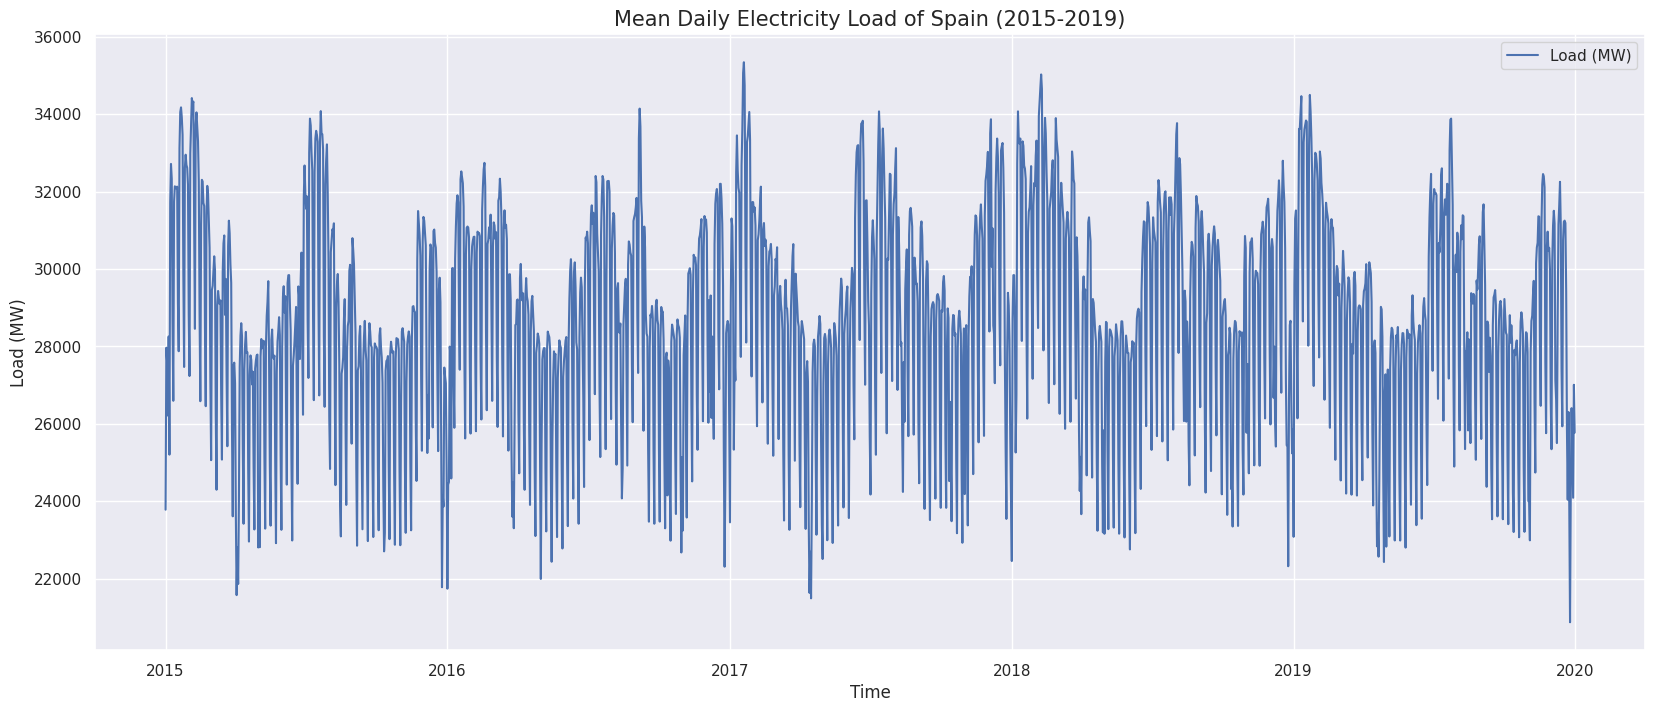

In [ ]:
# Resample the DataFrame to mean daily values
load = data['load'].resample('D').mean()
# Plot the load time series
x = load.index
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.lineplot(x=x, y=load, label='Load (MW)', ax=ax1)
plt.title('Mean Daily Electricity Load of Spain (2015-2019)', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel(legends[0], fontsize=12)
plt.show()

### STL decomposition

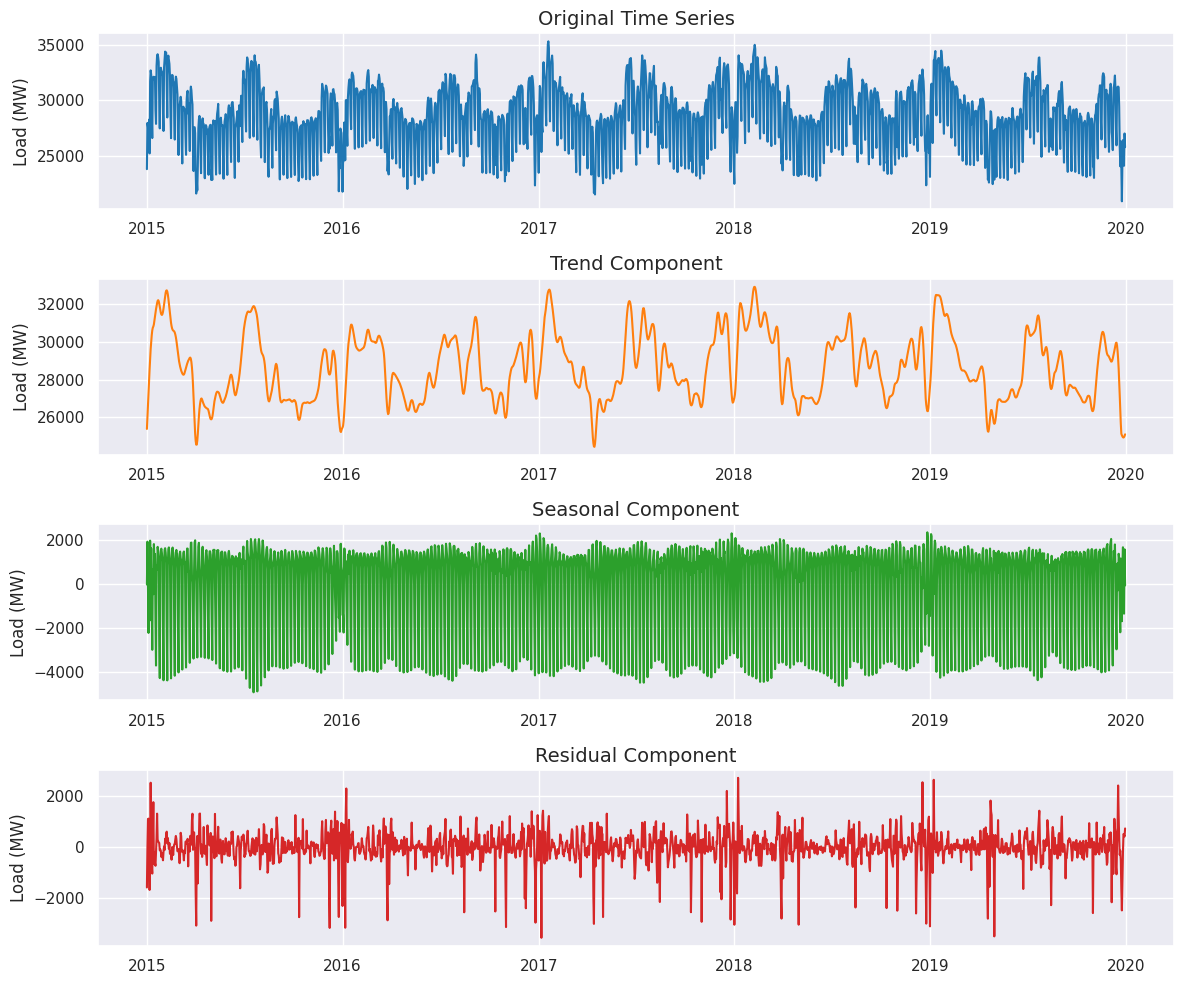

In [ ]:
# Resample the DataFrame to mean daily values
df = data['load'].resample('D').mean()

# Perform STL decomposition
stl = STL(df)
res = stl.fit()

# Plot the original time series, trend, seasonal, and residual components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

sns.lineplot(data=res.observed, color=colors[0], ax=axes[0])
sns.lineplot(data=res.trend, color=colors[1], ax=axes[1])
sns.lineplot(data=res.seasonal, color=colors[2], ax=axes[2])
sns.lineplot(data=res.resid, color=colors[3], ax=axes[3])

axes[0].set_title('Original Time Series', fontsize=14)
axes[1].set_title('Trend Component', fontsize=14)
axes[2].set_title('Seasonal Component', fontsize=14)
axes[3].set_title('Residual Component', fontsize=14)

for ax in axes:
  ax.set_ylabel(legends[0])
  ax.set_xlabel('')

plt.tight_layout()
plt.show()

### All years load

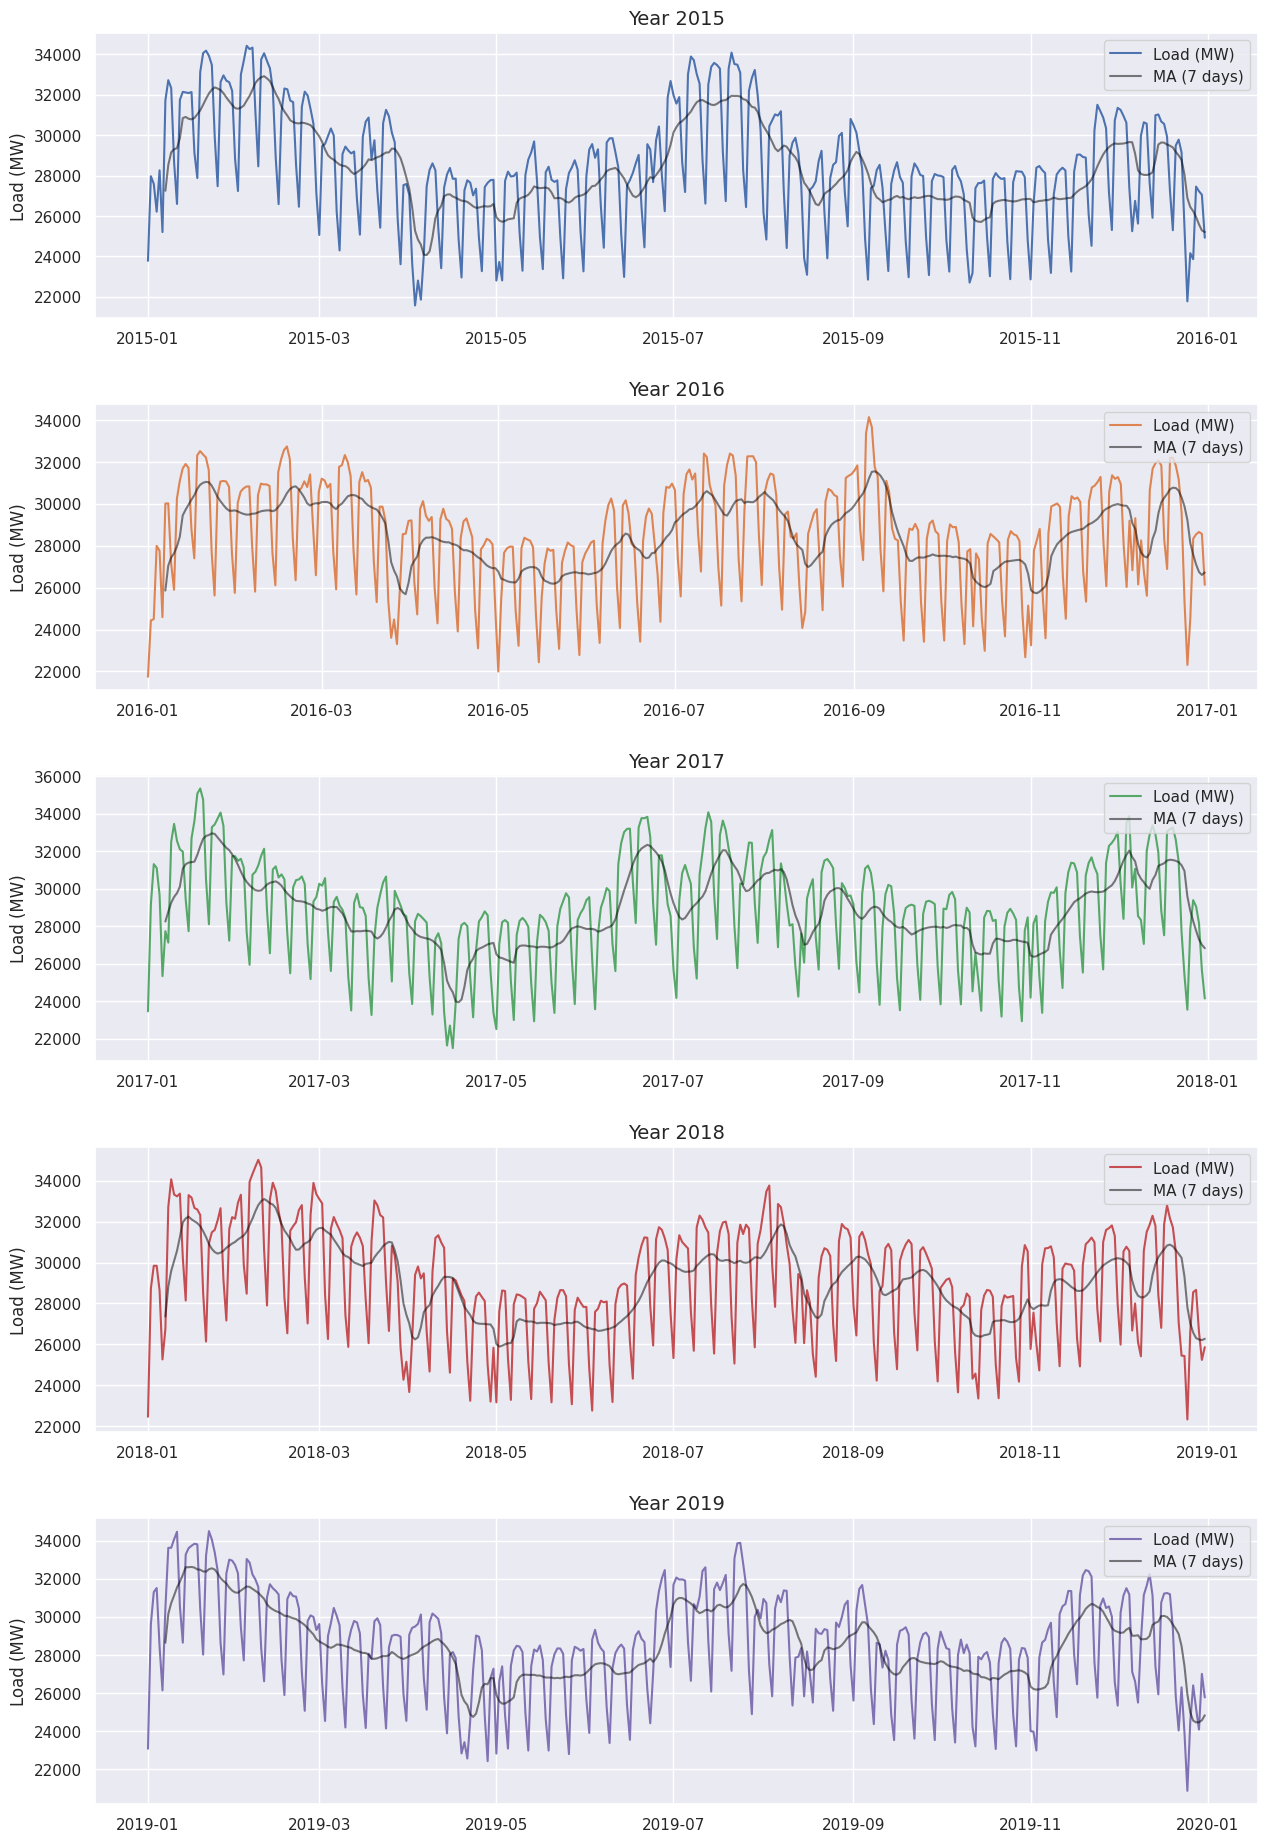

In [ ]:
# Create a figure with 5 subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 23))

colors = sns.color_palette()

# Iterate over the years and create a plot for each year
for i, year in enumerate(range(2015, 2020)):
    # Subset the data for the current year
    year_vals = data[data.index.year == year].resample('D').mean()
    rolling_avg = year_vals.rolling(window=7).mean() # Calclutate 7-day MovingAverage (MA)

    # Create a lineplot for the current year along with its MovingAverage
    sns.lineplot(data=year_vals, x=year_vals.index, y='load', label='Load (MW)', color=colors[i], ax=axes[i])
    sns.lineplot(data=rolling_avg, x=year_vals.index, y='load', label='MA (7 days)', alpha=0.5, color='black', ax=axes[i])

    axes[i].set_title(f'Year {year}', fontsize=14)
    axes[i].set_ylabel('Load (MW)')
    axes[i].set_xlabel('')
    axes[i].legend(loc='upper right')

plt.subplots_adjust(hspace=0.3) # Set padding between subplots
plt.show()

### Comparing years

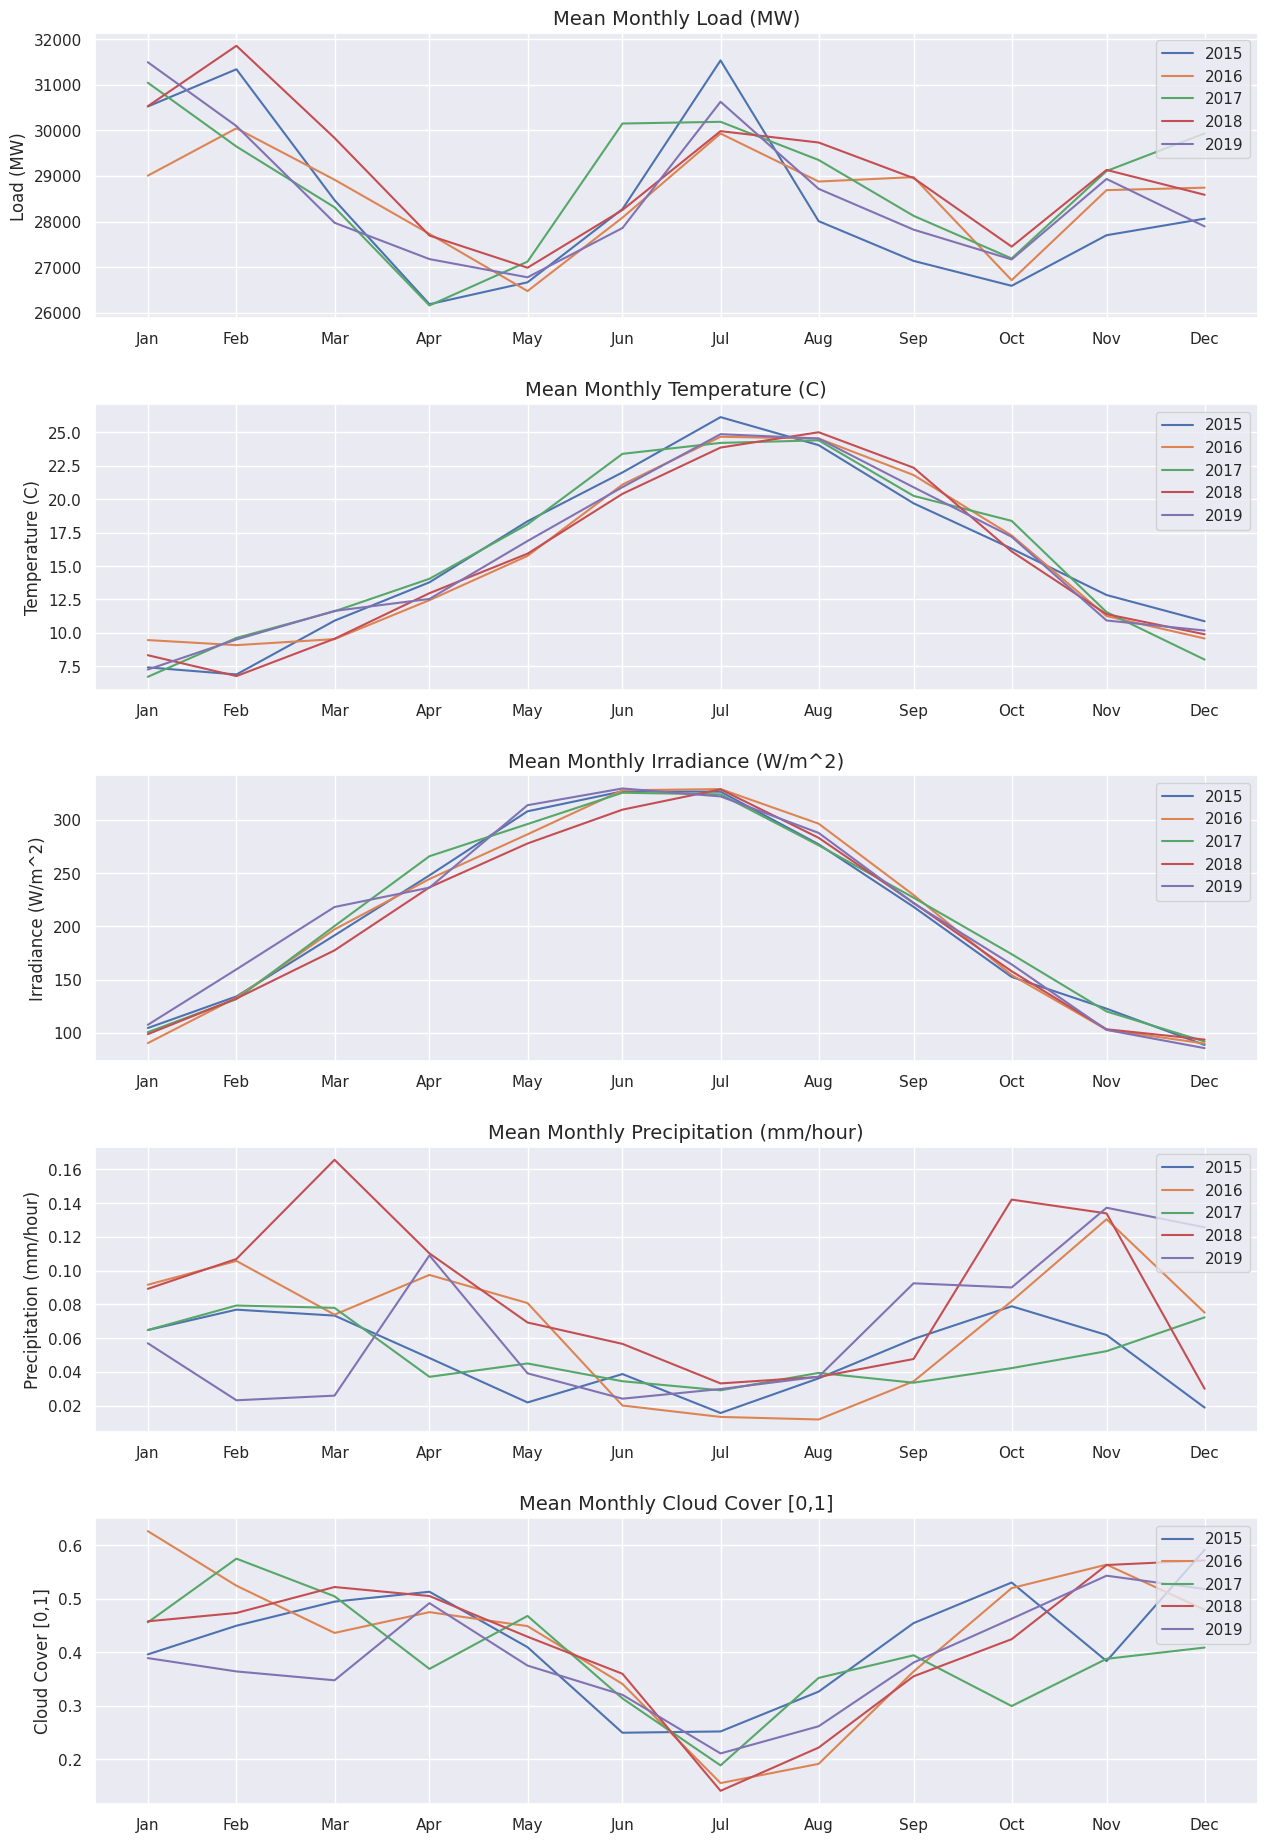

In [ ]:
# Create a figure with 5 subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 23))

years = [2015, 2016, 2017, 2018, 2019]
years_data = []

# Subset the data for the target year
for y in years:
  years_data.append(data[data.index.year == y].resample('M').mean()) # calculate the mean monthly values for each year

targets = ['load', 'temperature', 'irradiance_surface', 'precipitation', 'cloud_cover']

xticks = pd.date_range(start='2015-01-01', end='2015-12-31', freq='M')
xticklabels = [x.strftime('%b') for x in xticks]

# Plot all features' mean monthly values for each year (2015-2019)
for feature, ax in enumerate(axes):
  for year, d in enumerate(years_data):
    sns.lineplot(data=d[:365], x=years_data[0].index, y=targets[feature], label=years[year], color=colors[year], ax=ax)
  ax.set_title(f'Mean Monthly {legends[feature]}', fontsize=14)
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticklabels)
  ax.legend(loc='upper right')
  ax.set_ylabel(legends[feature])
  ax.set_xlabel('')


plt.subplots_adjust(hspace=0.3) # Set padding between subplots
plt.show()

### All features for 2015

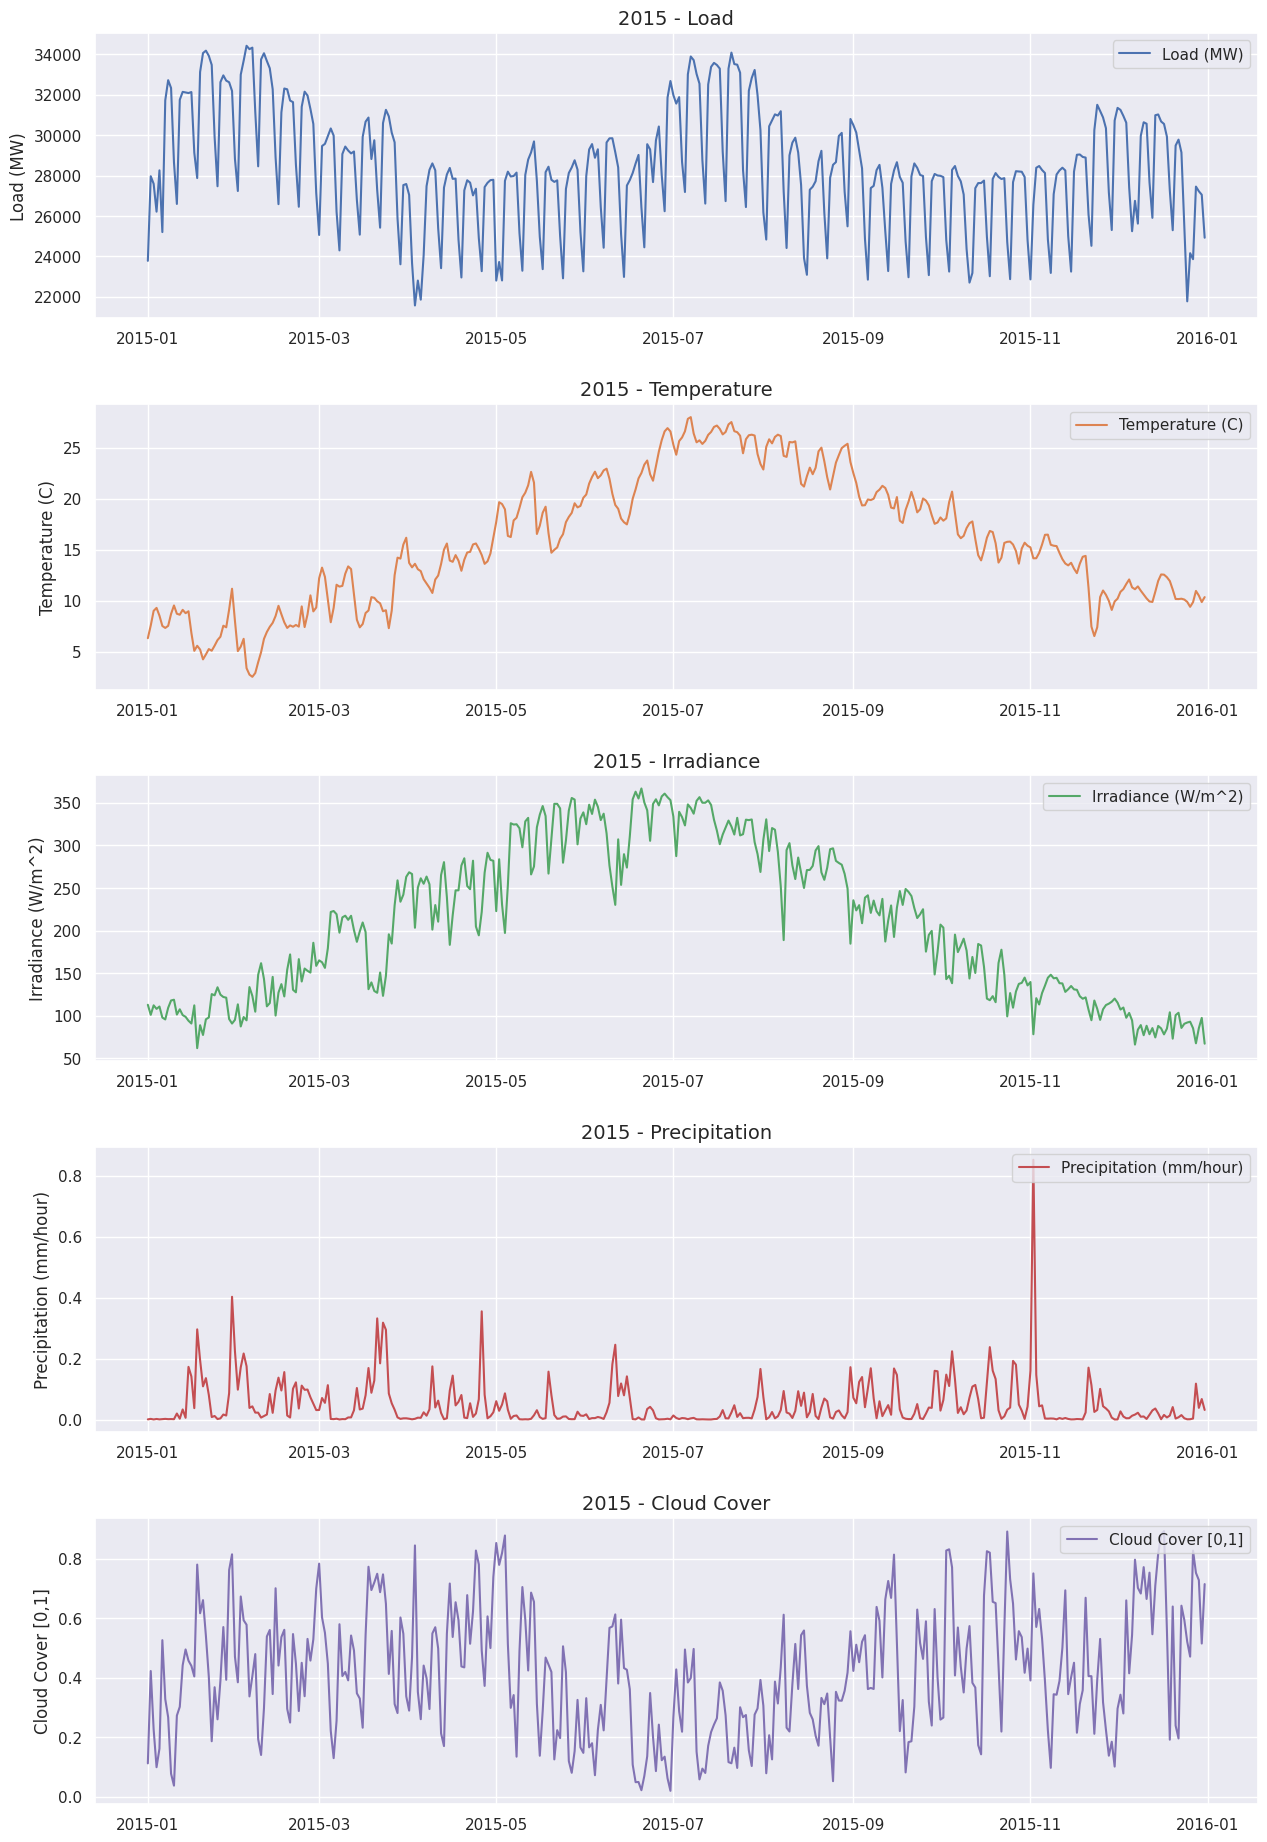

In [ ]:
year = 2015

# Create a figure with 5 subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 23))

# Calculate the daily mean data for the target year
year_vals = data[data.index.year == year].resample('D').mean()

# Create a lineplot for each feature
sns.lineplot(data=year_vals, x=year_vals.index, y='load', label=legends[0], color=colors[0], ax=axes[0])
sns.lineplot(data=year_vals, x=year_vals.index, y='temperature', label=legends[1], color=colors[1], ax=axes[1])
sns.lineplot(data=year_vals, x=year_vals.index, y='irradiance_surface', label=legends[2], color=colors[2], ax=axes[2])
sns.lineplot(data=year_vals, x=year_vals.index, y='precipitation', label=legends[3], color=colors[3], ax=axes[3])
sns.lineplot(data=year_vals, x=year_vals.index, y='cloud_cover', label=legends[4], color=colors[4], ax=axes[4])

# Set titles and labels
axes[0].set_title(f'{year} - Load', fontsize=14)
axes[1].set_title(f'{year} - Temperature', fontsize=14)
axes[2].set_title(f'{year} - Irradiance', fontsize=14)
axes[3].set_title(f'{year} - Precipitation', fontsize=14)
axes[4].set_title(f'{year} - Cloud Cover', fontsize=14)

for i in range(5):
  axes[i].set_ylabel(legends[i])
  axes[i].set_xlabel('')
  axes[i].legend(loc='upper right')

plt.subplots_adjust(hspace=0.3) # Set padding between subplots
plt.show()

### Load vs Temp

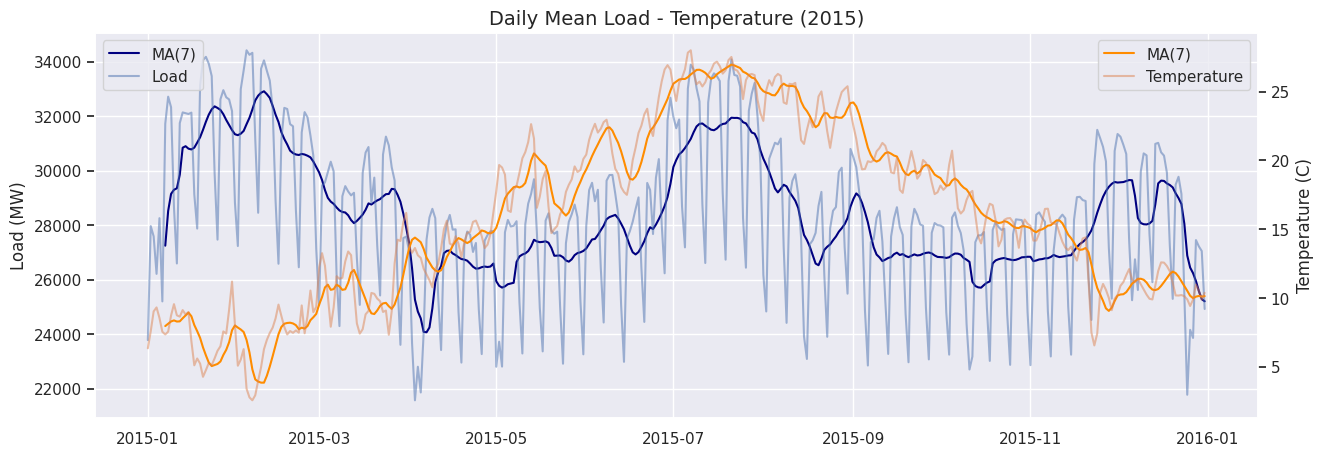

In [ ]:
year = 2015 # Target year
alpha = 0.5
window = 7 # Moving Average window

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

# Calculate the daily mean data for the target year
year_vals = data[data.index.year == year].resample('D').mean()
moving_average = year_vals.rolling(window=window).mean() # Calculate Moving Average

# Plot load
sns.lineplot(data=moving_average, x=year_vals.index, y='load', label=f'MA({window})', color='navy', ax=ax1)
sns.lineplot(data=year_vals, x=year_vals.index, y='load', label='Load', color=colors[0], ax=ax1, alpha=alpha)

# Plot temperature on the same axis
ax2 = ax1.twinx()
sns.lineplot(data=moving_average, x=year_vals.index, y='temperature', label=f'MA({window})', color='darkorange', ax=ax2)
sns.lineplot(data=year_vals, x=year_vals.index, y='temperature', label='Temperature', color=colors[1], ax=ax2, alpha=alpha)

# Set titles, labels, legends
ax1.set_title(f'Daily Mean Load - Temperature ({year})', fontsize=14)
ax2.grid(False)
ax1.set_xlabel('')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel(legends[0])
ax2.set_ylabel(legends[1])
plt.show()

### Temperature vs Irradiance

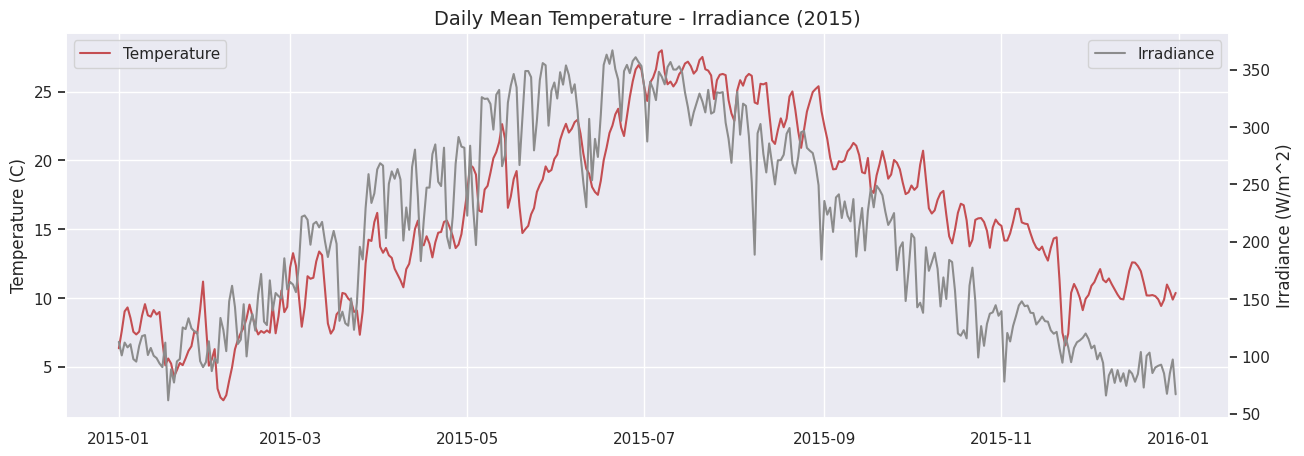

In [ ]:
year = 2015 # target year

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

# Calculate the daily mean data for the target year
year_vals = data[data.index.year == year].resample('D').mean()

# Plot temperature
sns.lineplot(data=year_vals, x=year_vals.index, y='temperature', label='Temperature', color=colors[3], ax=ax1)

# Plot irradiance on the same axis
ax2 = ax1.twinx()
sns.lineplot(data=year_vals, x=year_vals.index, y='irradiance_surface', label='Irradiance', color=colors[7], ax=ax2)

# Set titles, labels, legends
ax1.set_title(f'Daily Mean Temperature - Irradiance ({year})', fontsize=14)
ax2.grid(False)
ax1.set_xlabel('')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel(legends[1])
ax2.set_ylabel(legends[2])
plt.show()

### Hourly load for 4 days

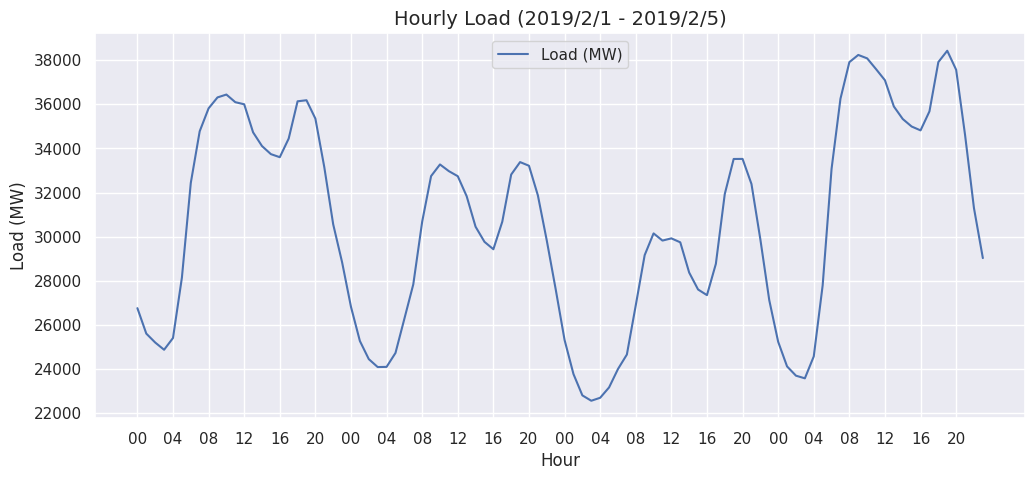

In [ ]:
start = '2019/2/1'
end   = '2019/2/5'

# Keep data within the specified range
load = data[(data.index >= start) & (data.index < end)]

fig, ax = plt.subplots(figsize=(12, 5))

# Plot the hourly load curve
sns.lineplot(data=load, x=load.index, y='load', label=legends[0], ax=ax)
plt.title(f'Hourly Load ({start} - {end})', fontsize=14)
plt.xlabel('Hour', fontsize=12)
plt.ylabel(legends[0], fontsize=12)

# Set the x-axis tick locations to every hour
xticks = pd.date_range(start=load.index.min().floor('H'), end=load.index.max().ceil('H'), freq='4H')
ax.set_xticks(xticks)
# Set the x-axis tick labels to only show the hour
xticklabels = [x.strftime('%H') for x in xticks]
ax.set_xticklabels(xticklabels)
ax.legend(loc='upper center')

plt.show()

## Preprocessing

### Z-score outlier detection

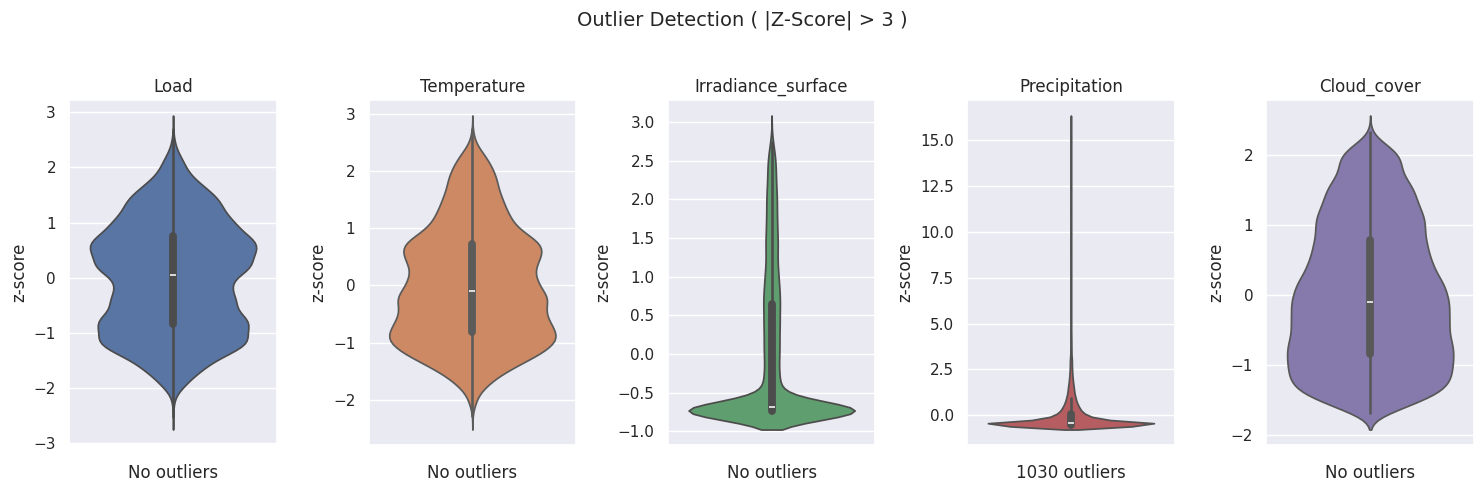

In [ ]:
def find_outliers(df):
  """
  Finds and plots outliers on each feature of a dataframe.

  Args
  ---------
  pd.DataFrame df: the original dataframe
  """
  # Create as many sublplots as the features
  fig, axes = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(15, 5))

  # for every feature of the data set
  for i, feature in enumerate(df.columns):
    d = df[feature]

    # calculate the Z-score of each data point
    z_scores = (d - d.mean()) / d.std()

    # identify any points with a Z-score > 3
    outliers = d[abs(z_scores) > 3]

    # create plot showing if there are any outliers
    sns.violinplot(data=z_scores, ax=axes[i], color=colors[i])

    title = 'No outliers'
    if len(outliers) > 0:
      title = f'{len(outliers)} outliers'

    axes[i].set_title(feature.capitalize())
    axes[i].set_ylabel('z-score')
    axes[i].set_xlabel(title)
    axes[i].set_xticklabels('')

  fig.suptitle("Outlier Detection ( |Z-Score| > 3 )\n", fontsize=14)
  plt.tight_layout()
  plt.show()
  return

colors = sns.color_palette()
sns.set_theme(style='darkgrid')
find_outliers(data)

### Augmentation

In [ ]:
# create a one-hot encoded day category dataframe
weekday_map = {'Monday':    'mon',
               'Tuesday':   'wkd',
               'Wednesday': 'wkd',
               'Thursday':  'wkd',
               'Friday':    'fri',
               'Saturday':  'wkn',
               'Sunday':    'wkn'}

day_cat = pd.get_dummies(data.index.day_name().map(weekday_map))[['mon', 'wkd', 'fri', 'wkn']]
day_cat

,mon,wkd,fri,wkn
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
43819,0,1,0,0
43820,0,1,0,0
43821,0,1,0,0
43822,0,1,0,0


In [ ]:
# # retrieve holiday list dictionary from the top-4 most populated provinces
years = range(2015, 2020)
provinces = ['MD', 'AN', 'CT', 'VC'] # [Madrid, Andalusia, Catalonia, Valencia]
holiday_list = hd.ES(years=years, prov=provinces[0])
for province in provinces:
  holiday_list.update(hd.ES(years=years, prov=province))

print(f'Number of total holidays: {len(holiday_list)}')

# create binary dataframe with value=1 if the day is a holiday
holidays = pd.DataFrame(data.index)
holidays['hld'] = 0
holidays.loc[holidays['date'].apply(lambda d: d in holiday_list), 'hld'] = 1
holidays = pd.DataFrame(holidays['hld'])
holidays.index = data.index
holidays

Number of total holidays: 93


,hld
date,
2015-01-01 00:00:00,1
2015-01-01 01:00:00,1
2015-01-01 02:00:00,1
2015-01-01 03:00:00,1
2015-01-01 04:00:00,1
...,...
2019-12-31 19:00:00,0
2019-12-31 20:00:00,0
2019-12-31 21:00:00,0


### Transformation

In [ ]:
# convert load from MW to GW
data['load'] /= 1000.0

In [ ]:
# Use Standard Scaliner to normalize all the unique data features
scalers = {}

for feature in data.columns:
  scaler = StandardScaler()
  data[feature] = scaler.fit_transform(np.array(data[feature]).reshape(-1, 1))
  scalers.update({feature: scaler})

In [ ]:
data.describe()

,load,temperature,irradiance_surface,precipitation,cloud_cover
count,4.382400e+04,4.382400e+04,4.382400e+04,4.382400e+04,4.382400e+04
mean,4.864066e-16,3.320536e-16,-2.594168e-17,-6.744838e-17,-1.219259e-16
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-2.518242e+00,-2.283490e+00,-7.421028e-01,-5.498245e-01,-1.687913e+00
25%,-8.471838e-01,-8.177143e-01,-7.421028e-01,-5.273822e-01,-8.391267e-01
50%,4.471504e-02,-1.044044e-01,-6.896978e-01,-4.056754e-01,-1.042268e-01
75%,7.615632e-01,7.168984e-01,6.509381e-01,6.043541e-02,7.755073e-01
max,2.704697e+00,2.733647e+00,2.845695e+00,1.611623e+01,2.320819e+00


## Feature Extraction

```
[ X data ]
--------------------------------
H1. Consumption   Nd X 24h
H2. Temperature   Nd X 24h
H3. Irradiance    Nd X 24h
H4. Precipitation Nd X 24h
H5. Cloud Cover   Nd X 24h

F1. Temperature Forecast   24h
F2. Irradiance Forecast    24h
F3. Precipitation Forecast 24h
F4. Cloud Cover Forecast   24h

C1. Day-ahead Day Number    1
C2. Day-ahead Month Number  1
C3. Day-ahead Day Category  4
C4. Day-ahead Holiday       1

[ Y data ]
--------------------------------
Y1. Consumption Forecast 24h
```

In [ ]:
def extract_features(days_back, data, day_cat, holidays):
  """
  Calculates feature vectors, specified by the days_back properties
  dictionary and returns the X and Y arrays with the preprocessed data.

  Args
  ---------
  dict days_back: properties for days_back count to be considered for feature vectors
  pd.DataFrame data: concatenated consumption and weather data features
  pd.DataFrame day_cat: one-hot encoded day category dataframe
  pd.DataFrame holidays: binary holiday indicator dataframe

  Returns
  -------
  np.ndarray X: shape=(n_days, n_features), represents input x data
  np.ndarray Y: shape=(n_days, 24), represents target y data
  """
  X = []
  Y = []

  first_black_day = max(days_back.values())
  print(first_black_day) # find the first black day

  # iterate through all black days
  for day_id in range(first_black_day, (data.shape[0]-24)//24):

    # Calculate historical load and weather features
    H1 = data['load'].iloc[(day_id-days_back['load'])*24:(day_id)*24]
    H2 = data['temperature'].iloc[(day_id-days_back['temperature'])*24:(day_id)*24]
    H3 = data['irradiance_surface'].iloc[(day_id-days_back['irradiance_surface'])*24:(day_id)*24]
    H4 = data['precipitation'].iloc[(day_id-days_back['precipitation'])*24:(day_id)*24]
    H5 = data['cloud_cover'].iloc[(day_id-days_back['cloud_cover'])*24:(day_id)*24]

    next24h = range((day_id)*24, (day_id+1)*24) # calculate the range for the next 24h (used for weather forecasts)
    next1d = (day_id+1)*24 # the id of the next day

    # Calculate simulated day-ahead weather forecast
    F1 = data['temperature'].iloc[next24h]
    F2 = data['irradiance_surface'].iloc[next24h]
    F3 = data['precipitation'].iloc[next24h]
    F4 = data['cloud_cover'].iloc[next24h]

    # Retrieve day-ahead calendar features
    C1 = int(data.index.day[next1d])
    C2 = int(data.index.month[next1d])
    C3 = np.array(day_cat.iloc[next1d])
    C4 = int(holidays.iloc[next1d])
    calendar = np.concatenate((np.array([C1, C2]), C3, np.array([C4])))

    # Create the X feature vector by combining all of the above
    feature_vec = np.concatenate((H1, H2, H3, H4, H5, F1, F2, F3, F4, calendar))
    X.append(feature_vec)

    # Create the Y feature vector by retrieving the actual day-ahead load values
    Y1 = data['load'].iloc[(day_id+1)*24:(day_id+2)*24]
    Y.append(np.array(Y1))

  return np.array(X, dtype='float64'), np.array(Y, dtype='float64')

In [ ]:
def split_train_test_val(A):
  """
  Splits data into train, validation and test sets.

  Args
  ---------
  np.ndarray A: shape=(n_days, n_features) feature vector table

  Returns
  -------
  np.ndarray train: the train set
  np.ndarray val:   the validation set
  np.ndarray test:  the test set
  """

  n_instances = A.shape[0]

  n_val = 365  # Keep a year's worth of validation data
  n_test = 365 # Keep a year's worth of testing data
  n_train = n_instances - n_val - n_test # Leave the rest for training

  indices = range(A.shape[0])

  train = A[indices[:n_train]] # Years 2015-2017: training data
  val   = A[indices[n_train:n_train+n_val]] # Year 2018: validation data
  test  = A[indices[n_train+n_val:]] # Year 2019: testing data

  return train, val, test

In [ ]:
# specifies the days_back amount that will be considered for each historical feature value (H1-H5)
days_back = {
    'load': 7,
    'temperature': 7,
    'irradiance_surface': 7,
    'precipitation': 7,
    'cloud_cover': 7,
}

In [ ]:
print((data.shape[0]-24)//24)

1825


In [ ]:
# extract features and print shapes
X, Y = extract_features(days_back, data, day_cat, holidays)
n_features = X.shape[1]
print(X.shape, Y.shape)

7
(1818, 943) (1818, 24)


In [ ]:
print(n_features)

943


In [ ]:
# split the data into train, validation and test sets
x_train, x_val, x_test = split_train_test_val(X)
y_train, y_val, y_test = split_train_test_val(Y)

In [ ]:
# confirm that the shapes are as needed
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1088, 943) (365, 943) (365, 943)
(1088, 24) (365, 24) (365, 24)


In [ ]:
model = tf.keras.Sequential([
    Input(shape=(n_features, 1)),
    Conv1D(336, kernel_size=4, activation='tanh'),
    MaxPooling1D(pool_size=4),
    Dropout(0.2),
    LSTM(48, return_sequences=True),
    Dropout(0.),
    Flatten(),
    Dense(24)
])

model.compile(loss='mse', optimizer=Adam(learning_rate=0.0023))

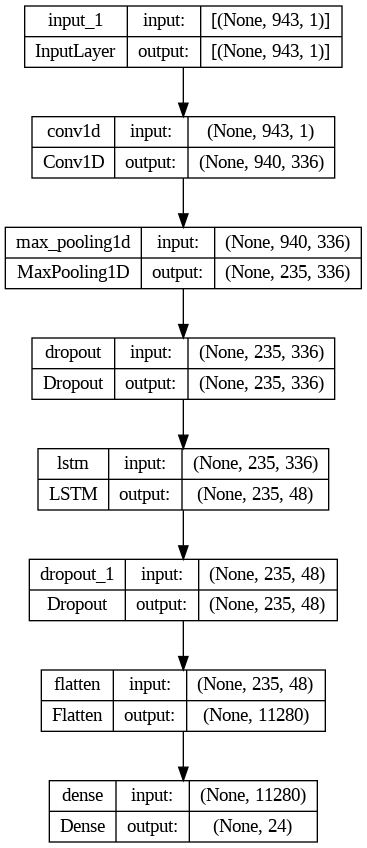

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# Use the loss checkpoint callback
loss_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=models_path+'model_weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Define the input shape and batch size
batch_size = 16
epochs = 100

# Fit the model with training data and validate with validation data
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[loss_checkpoint]
)

# retrieve the weights of the best epoch
model.load_weights(models_path+'model_weights.h5')

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.3118
Epoch 1: val_loss improved from inf to 0.24349, saving model to /content/drive/MyDrive/Model/model_weights.h5
68/68 [==============================] - 21s 260ms/step - loss: 0.3118 - val_loss: 0.2435
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.2042
Epoch 2: val_loss improved from 0.24349 to 0.18944, saving model to /content/drive/MyDrive/Model/model_weights.h5
68/68 [==============================] - 10s 152ms/step - loss: 0.2042 - val_loss: 0.1894
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.1635
Epoch 3: val_loss improved from 0.18944 to 0.14026, saving model to /content/drive/MyDrive/Model/model_weights.h5
68/68 [==============================] - 8s 116ms/step - loss: 0.1635 - val_loss: 0.1403
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 0.1324
Epoch 4: val_loss did not improve from 0.14026
68/68 [==============================] - 8

KeyboardInterrupt: 

In [ ]:
# Load weights of best epoch
model.load_weights(models_path+'model_weights.h5')

In [ ]:
# plot the training and validation loss progression
fig, ax = plt.subplots(figsize=(10, 5))

# plot loss curves
sns.lineplot(data=history.history['loss'], label='Training', linewidth=2)
sns.lineplot(data=history.history['val_loss'], label='Validation', linewidth=2)

# mark best epoch
best_epoch = np.argmin( history.history['val_loss']) + 1
pos = ax.get_ylim()[0]
plt.plot(best_epoch-1, pos, '*', markersize=10, color='black', alpha=0.5)
plt.plot(best_epoch-1, pos, '*', markersize=6, color='gold', label='Best Epoch')

# set ticks
ticks = list(range(25, 125, 25))
ticks = [1, best_epoch] + ticks
ticks.sort()
ax.set_xticks([t-1 for t in ticks])
ax.set_xticklabels(ticks)

# mark label of best epoch as bold
for label in ax.get_xticklabels():
  if label.get_text() == str(best_epoch):
    label.set_weight('semibold')
    label.set_fontsize(10)

plt.title('Training / Validation Loss', fontsize=14)
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Results

In [ ]:
def predict(model, x, y):
  """
  Generates predictions of a model and calculates the MAPE score.

  Args
  ---------
  tf.keras.Sequential model: the ANN model to generate predictions from
  np.ndarray x: the normalized input data to make predictions from
  np.ndarray y: the normalized actual output data

  Returns
  -------
  np.ndarray y_pred: the predicions of the y data
  np.ndarray y_true: the actual y values
  float err: the MAPE score
  """
  # Generate prediction
  y_pred = model.predict(x, verbose=0)
  # Undo normalization of load values
  y_pred = scalers['load'].inverse_transform(y_pred)
  y_true = scalers['load'].inverse_transform(y)
  # Calculate MAPE score
  err = mape(y_true, y_pred)

  return y_pred, y_true, err

In [ ]:
def calculate_error_metrics(true, pred):
    return {
        'MAPE (%)': 100 * mape(true, pred),
        'MSE': MSE(true, pred),
        'RMSE': MSE(true.reshape(-1), pred.reshape(-1), squared=False),
        'MAE': MAE(true, pred)
    }

In [ ]:
# Calculate MAPE scores for the training, validation and testing set
train_pred, train_true, train_err = predict(model, x_train, y_train)
val_pred, val_true, val_err       = predict(model, x_val, y_val)
test_pred, test_true, test_err    = predict(model, x_test, y_test)

print(f"Training   MAPE = {100 * train_err:.2f}%")
print(f"Validation MAPE = {100 * val_err:.2f}%")
print(f"Testing    MAPE = {100 * test_err:.2f}%")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Define a function to plot actual vs. predicted values with the fitting line
def plot_fitting_line(y_true, y_pred, set_name):
    plt.scatter(y_true, y_pred, color='blue', label=f'Actual vs. Predicted ({set_name})')
    plt.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], linestyle='--', color='red', linewidth=2, label='Fitting Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{set_name} Set Fitting Line')
    plt.legend()
    plt.show()

# Calculate MAPE scores for the training, validation, and testing sets
train_err = calculate_mape(train_true, train_pred)
val_err = calculate_mape(val_true, val_pred)
test_err = calculate_mape(test_true, test_pred)

# Print MAPE scores
print(f"Training   MAPE = {100 * train_err:.2f}%")
print(f"Validation MAPE = {100 * val_err:.2f}%")
print(f"Testing    MAPE = {100 * test_err:.2f}%")

# Plot fitting lines for each set
plot_fitting_line(train_true, train_pred, 'Training')
plot_fitting_line(val_true, val_pred, 'Validation')
plot_fitting_line(test_true, test_pred, 'Testing')


In [ ]:
# Calculate all loss metric scores for the training, validation and testing set
pairs = [(train_true, train_pred), (val_true, val_pred), (test_true, test_pred)]

errors = pd.DataFrame({
    'MAPE (%)': [100 * mape(true, pred) for (true, pred) in pairs],
    'MSE': [MSE(true, pred) for (true, pred) in pairs],
    'RMSE': [MSE(true.reshape(-1), pred.reshape(-1), squared=False) for (true, pred) in pairs],
    'MAE': [MAE(true, pred) for (true, pred) in pairs]
}, index=['Training', 'Validation', 'Testing'])
print('\033[1;30;30m             LSTM Evaluation Metrics\033[0m')

errors.round(4)

In [ ]:
sns.set_theme(style="ticks")

In [ ]:
def plot_predictions(data, title=None):
  """
  Plots the real vs prediction load values and calculates the MAPE score.

  Args
  ---------
  pd.DataFrame data: dataframe containing the real and predicted load values
  str title: if specified, replaces the default graph title

  Returns
  -------
  float: MAPE score
  """

  fig, ax = plt.subplots(figsize=(15, 6))

  # Create a line plot with real vs predicted values
  sns.lineplot(x=data.index, y=data['real'], label='Real', linewidth=2)
  sns.lineplot(x=data.index, y=data['predicted'], label='Predicted', linewidth=2)

  # Specify ticks and labels
  plt.set_xticklabels = [d.strftime('%m/%d %Hh') for d in data.index]
  plt.xticks(rotation=15)
  plt.title(title if title else f"Predictions", fontsize=14)
  plt.ylabel("Load (GW)")
  plt.xlabel("Time")
  plt.show()

  # return the MAPE for the plotted values
  return 100 * mape(data['real'], data['predicted'])

In [ ]:
def plot_monthly_predictions(data, monthID=1, resolution='H', title=None):
  """
  Plots the real vs prediction load values of an entire month with the specified resolution.

  Args
  ---------
  pd.DataFrame data: dataframe containing the real and predicted load values
  int monthID: integer [1, 12] specifying the month number
  str resolution: the resolution of the plotted data (hourly, daily, etc.)
  str title: if specified, replaces the default graph title

  Returns
  -------
  float: MAPE score through the plot_predictions function
  """

  # Pick the data for plotting, by only choosing the specified month from the full data
  plot_data = full_data.loc[full_data.index.month == monthID]
  plot_data = plot_data.resample(resolution).sum()

  return plot_predictions(plot_data, title)

In [ ]:
def plot_predictions_between(data, start='2019-01-01', end='2019-12-31 23:00:00', resolution='H', title=None):
  """
  Plots the real vs prediction load values between 2 specified dates.

  Args
  ---------
  pd.DataFrame data: dataframe containing the real and predicted load values
  str start: the start date as YYYY-MM-DD
  str end: the end date as YYYY-MM-DD
  str resolution: the resolution of the plotted data (hourly, daily, etc.)
  str title: if specified, replaces the default graph title

  Returns
  -------
  float: MAPE score through the plot_predictions function
  """

  # Pick the data for plotting, by only choosing the specified range from the full data
  plot_data = data.loc[(data.index >= start) & (data.index <= end)]
  plot_data = plot_data.resample(resolution).sum()

  return plot_predictions(plot_data, title)

In [ ]:
# Create a dataframe with real and predicted feature columns for the entire data set
index = pd.date_range(start='2019-01-01', end='2019-12-31 23:00:00', freq='H')

full_data = pd.DataFrame({
    'real': test_true.reshape(-1),
    'predicted': test_pred.reshape(-1)
}, index=index)

In [ ]:
# Plot the aggregated daily forecast for the entire test year of 2019
e = plot_predictions_between(full_data, resolution='D', title='Aggregated Daily Forecast 2019')

In [ ]:
def prediction_interval(y_pred, y_true, interval):
  """
  Checks what percentage of the true values fall within a specified interval range around the predictions.

  Args
  ---------
  np.ndarray y_pred: the predicted load values
  np.ndarray y_true: the actual load values
  float interval: represents the percentage of the lower and upper bounds of the interval zone
  """

  # Compute the lower and upper bounds of the interval
  lower_bound = 1.0 - interval
  upper_bound = 1.0 + interval

  # Compute the minimum and maximum values for each y_pred element
  min_values = y_pred.reshape(-1) * lower_bound
  max_values = y_pred.reshape(-1) * upper_bound

  # Check if each y_true element falls within the interval of y_pred
  within_interval = np.logical_and(y_true.reshape(-1) >= min_values, y_true.reshape(-1) <= max_values)
  # Compute the percentage of values that fall within the interval
  percentage_within_interval = 100.0 * np.sum(within_interval) / np.prod(y_true.reshape(-1).shape)

  print(f"{percentage_within_interval:.2f}% of actual values fall within a {interval*100:.1f}% interval of predictions")

prediction_interval(test_pred, test_true, 0.20)
prediction_interval(test_pred, test_true, 0.1)
prediction_interval(test_pred, test_true, 0.05)

In [ ]:
# Function to plot fitting lines for each set
def plot_fitting_line(y_true, y_pred, set_name):
    plt.scatter(y_true, y_pred, color='blue', label=f'Actual vs. Predicted ({set_name})')
    plt.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], linestyle='--', color='red', linewidth=2, label='Fitting Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Scatter Plot - {set_name}')
    plt.legend()
    plt.show()

# Plot fitting lines for each set
plot_fitting_line(train_true, train_pred, 'Training')
plot_fitting_line(val_true, val_pred, 'Validation')
plot_fitting_line(test_true, test_pred, 'Testing')


In [ ]:
# Compute the MAPE score for each month separately
monthly_errors = []
for i in range (1, 13):
  month = full_data.loc[full_data.index.month == i]
  err = 100 * mape(month['real'], month['predicted'])
  monthly_errors.append(err)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_mapes = pd.DataFrame([monthly_errors], columns=month_names, index=['MAPE (%)']).round(2)
monthly_mapes

In [ ]:
# Create a lineplot for each month's MAPE
sns.lineplot(x=range(1, 13), y=monthly_errors, linewidth=2.5)
plt.axhline(y=np.mean(monthly_errors), color='grey', linestyle='--', label='Average')
plt.title('Monthly MAPE on Testing Set')
plt.xticks(range(1,13), month_names)
plt.ylabel('MAPE (%)')
plt.xlabel('Months')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# Plot the predicted vs real values of the best and worst month
_ = plot_monthly_predictions(full_data, monthID=3, resolution='H', title='March Hourly Forecast') # best
_ = plot_monthly_predictions(full_data, monthID=12, resolution='H', title='December Hourly Forecast') # worst

In [ ]:
# Find the best and worst single days in terms of forecast error

# Calculate the absolute percentage error between actual and predicted values
APE = np.abs((full_data['predicted'] - full_data['real']) / full_data['real'])
# Calculate the MAPE with daily resolution
mapes = APE.resample('D').mean()

# Get top-5 days with lowest MAPE
best = [(round(100*mapes.loc[id], 2), id.strftime('%Y-%m-%d')) for id in mapes.nsmallest(5).index]
# Get bottom-5 days in terms of MAPE
worst = [(round(100*mapes.loc[id], 2), id.strftime('%Y-%m-%d')) for id in mapes.nlargest(5).index]

# Print results
print('Best Forecast Days:')
for err, day in best:
  print(f'{day} --> MAPE={err}')
print()
print('Worst Forecast Days:')
for err, day in worst:
  print(f'{day} --> MAPE={err}')

In [ ]:
# Create a boxplot with the MAPE distribution for daily forecasts
fig = plt.figure(figsize=(5, 6))
sns.boxplot(100*mapes, orient='v', color='orange')
plt.ylabel('MAPE (%)')
plt.yticks(range(0, 24, 2))
plt.xticks([])
plt.title('Daily MAPE Distribution')
plt.show()

In [ ]:
# Find the MAPE scores for each day group
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print('MAPE score of each day group:\n')

for i in range(7):
  day = full_data.loc[full_data.index.weekday == i]
  err = mape(day['real'], day['predicted'])
  print(f'{day_names[i]:9} {100*err:.2f}%')

In [ ]:
def get_random_date():
  """
  Generates a random date from 2019

  Returns
  ---------
  str dayname: the name of the day (Monday, Tuesday, etc.)
  str date: the random date formatted as YYYY-MM-DD
  """
  start_date = datetime.date(2019, 1, 1)
  end_date = datetime.date(2019, 12, 31)
  date = start_date + datetime.timedelta(days=random.randint(0, (end_date - start_date).days))
  dayname = date.strftime('%A')
  return dayname, str(date)

In [ ]:
# Plots real vs predicted load values for 8 random days from the data set
fig, axes = plt.subplots(4, 2, figsize=(20, 25))

# for each subplot
for ax in axes.flatten():

  # Get a random day and calculate the MAPE
  day_name, date = get_random_date()
  plot_data = full_data.loc[(full_data.index >= date) & (full_data.index <= date+' 23:00:00')]
  err = mape(plot_data['real'], plot_data['predicted'])

  # Create the load curves plot
  sns.lineplot(x=plot_data.index, y=plot_data['real'], label='Real', linewidth=2, ax=ax)
  sns.lineplot(x=plot_data.index, y=plot_data['predicted'], label='Predicted', linewidth=2, ax=ax)

  # Set labels and title
  ax.set_xticklabels([f'{i:02d}:00' for i in range(0, 25, 3)])
  ax.set_title(f'{day_name} {date}\nMAPE {100*err:.2f}%', fontsize=14)
  ax.set_ylabel("Load (GW)")
  ax.set_xlabel('')

fig.subplots_adjust(hspace=0.4)
plt.show()

## Comparison with other Forecasting Models

In [ ]:
# The unnormalized true load values of the testing set
y_true = scalers['load'].inverse_transform(y_test)
y_tra =scalers['load'].inverse_transform(y_train)

In [ ]:
def print_error_metrics(y_pred, y_true):
  """
  Prints the MAPE, MSE, RMSE, MAE score of a model
  given a prediction and a true vector

  Args
  ---------
  np.ndarray y_pred: normalized predictions on test data
  np.ndarray y: de-normalized real load values of test data
  """
  print(f'MAPE = {100 * mape(y_true, y_pred):.2f}%')
  print(f'MSE  = {MSE(y_true, y_pred):.4f}')
  print(f'RMSE = {MSE(y_true.reshape(-1), y_pred.reshape(-1), squared=False):.4f}')
  print(f'MAE  = {MAE(y_true, y_pred):.4f}')

In [ ]:
from tabulate import tabulate

def get_error_metrics(y_pred, y_true, set_name):
    """
    Returns a dictionary with MAPE, MSE, RMSE, MAE scores.

    Args:
    y_pred (np.ndarray): Predicted values.
    y_true (np.ndarray): True values.
    set_name (str): Name of the dataset (e.g., 'Training', 'Testing').

    Returns:
    dict: Dictionary with error metrics.
    """
    mape_value = 100 * mape(y_true, y_pred)
    mse_value = MSE(y_true, y_pred)
    rmse_value = MSE(y_true.reshape(-1), y_pred.reshape(-1), squared=False)
    mae_value = MAE(y_true, y_pred)

    return {
        "Dataset": set_name,
        "MAPE": f"{mape_value:.2f}%",
        "MSE": f"{mse_value:.4f}",
        "RMSE": f"{rmse_value:.4f}",
        "MAE": f"{mae_value:.4f}"
    }

### ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Flatten the target variable to apply ARIMA to the whole dataset
y_train_flat = y_train.flatten()

# Create an ARIMA model and fit it on the training set
arima_model_train = ARIMA(y_train_flat, order=(1, 1, 1))
model_fit_train = arima_model_train.fit()

# Make predictions on the training set
arima_pred_train = model_fit_train.fittedvalues
arima_pred_train = arima_pred_train.reshape(y_train.shape)

In [ ]:


# Create an ARIMA model and test the loss scores of the predictions on the test set
arima_pred_test = []

for i in range(y_train.shape[1]):
    y_train_col = y_train[:, i]

    arima_model_test = ARIMA(y_train_col, order=(1, 0, 0))
    model_fit_test = arima_model_test.fit()

    preds = model_fit_test.forecast(steps=len(y_test))
    arima_pred_test.append(preds)

arima_pred_test = np.array(arima_pred_test).T
arima_pred_test = scalers['load'].inverse_transform(arima_pred_test)


In [ ]:
# Calculate error metrics for Linear Regression on the first dataset
arima_pred_test_1 = get_error_metrics(arima_pred_train, y_tra, "ARIMA (Training)")

# Calculate error metrics for Linear Regression on the second dataset
arima_pred_test_2 = get_error_metrics(arima_pred_test, y_true, "ARIMA (Testing)")

# Combine the metrics into a list
all_metrics = [arima_pred_test_1, arima_pred_test_2]

# Convert the list of dictionaries to a tabular format with changed outlines and added color
table1 = tabulate(all_metrics, headers="keys", tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"), numalign="center")

# Display the table
print(table1)

In [ ]:
print('ARIMA\n')
print_error_metrics(arima_pred, y_true)

### Linear Regression

In [ ]:
# Create a Linear Regression model and test the loss scores of the predictions
linreg_model = LinearRegression()
linreg_model.fit(x_train, y_train)
linreg_pred1 = linreg_model.predict(x_test)
linreg_pred2 = linreg_model.predict(x_train)
linreg_pred1 = scalers['load'].inverse_transform(linreg_pred1)
linreg_pred2 = scalers['load'].inverse_transform(linreg_pred2)

In [ ]:
# Calculate error metrics for Linear Regression on the first dataset
linear_regression_metrics_2 = get_error_metrics(linreg_pred1, y_true, "Linear Regression (Testing)")

# Calculate error metrics for Linear Regression on the second dataset
linear_regression_metrics_1 = get_error_metrics(linreg_pred2, y_tra, "Linear Regression (Training)")

# Combine the metrics into a list
all_metrics = [linear_regression_metrics_1, linear_regression_metrics_2]

# Convert the list of dictionaries to a tabular format with changed outlines and added color
table2 = tabulate(all_metrics, headers="keys", tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"), numalign="center")

# Display the table
print(table2)


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_tra, linreg_pred2, color='blue', label='Actual vs. Predicted (Linear Regression - Training)')
plt.plot([np.min(y_tra), np.max(y_tra)], [np.min(y_tra), np.max(y_tra)], linestyle='--', color='red', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression Model Fitting Line - Training Set')
plt.legend()
plt.show()

# Scatter plot with fitting line for Linear Regression on test set
plt.figure(figsize=(10, 6))
plt.scatter(y_true, linreg_pred1, color='green', label='Actual vs. Predicted (Linear Regression - Testing)')
plt.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], linestyle='--', color='orange', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression Model Fitting Line - Testing Set')
plt.legend()
plt.show()

### Random Forest

In [ ]:
# Create a Random Forest Regressor model and test the loss scores of the predictions
rf_model = RandomForestRegressor(random_state=0, n_estimators=10)
rf_model.fit(x_train, y_train)
rf_pred1 = rf_model.predict(x_train)
rf_pred2 = rf_model.predict(x_test)
rf_pred1 = scalers['load'].inverse_transform(rf_pred1)
rf_pred2 = scalers['load'].inverse_transform(rf_pred2)

In [ ]:
# Calculate error metrics for Linear Regression on the first dataset
Random_Forest_metrics_1 = get_error_metrics(rf_pred1, y_tra, "Random Forest (Traning)")

# Calculate error metrics for Linear Regression on the second dataset
Random_Forest_metrics_2 = get_error_metrics(rf_pred2, y_true, "Random Forest (Testing)")

# Combine the metrics into a list
all_metrics = [Random_Forest_metrics_1, Random_Forest_metrics_2]

# Convert the list of dictionaries to a tabular format with changed outlines and added color
table3 = tabulate(all_metrics, headers="keys", tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"), numalign="center")

# Display the table
print(table3)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot with fitting line for Random Forest on training set
plt.figure(figsize=(10, 6))
plt.scatter(y_tra, rf_pred1, color='blue', label='Actual vs. Predicted (Random Forest - Training)')
plt.plot([np.min(y_tra), np.max(y_tra)], [np.min(y_tra), np.max(y_tra)], linestyle='--', color='red', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Model Fitting Line - Training Set')
plt.legend()
plt.show()

# Scatter plot with fitting line for Random Forest on testing set
plt.figure(figsize=(10, 6))
plt.scatter(y_true, rf_pred2, color='green', label='Actual vs. Predicted (Random Forest - Testing)')
plt.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], linestyle='--', color='orange', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Model Fitting Line - Testing Set')
plt.legend()
plt.show()


### kNN

In [ ]:
# Create a kNN Regressor model and test the loss scores of the predictions
knn_model = KNeighborsRegressor()
knn_model.fit(x_train, y_train
              )
knn_pred = knn_model.predict(x_test)
knn_pred = scalers['load'].inverse_transform(knn_pred)

In [ ]:
knn_mape=predict()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Create a kNN Regressor model
knn_model = KNeighborsRegressor()
knn_model.fit(x_train, y_train)

# Get predictions on the training and testing sets
knn_pred_train = knn_model.predict(x_train)
knn_pred_test = knn_model.predict(x_test)

# Inverse transform predictions to the original scale
knn_pred_train = scalers['load'].inverse_transform(knn_pred_train)
knn_pred_test = scalers['load'].inverse_transform(knn_pred_test)

# Calculate error metrics for kNN on training set
knn_metrics_train = get_error_metrics(knn_pred_train, y_tra, "kNN (Training)")

# Calculate error metrics for kNN on testing set
knn_metrics_test = get_error_metrics(knn_pred_test, y_true, "kNN (Testing)")

# Combine the metrics into a list
all_metrics = [knn_metrics_train, knn_metrics_test]

# Convert the list of dictionaries to a tabular format with changed outlines and added color
table4 = tabulate(all_metrics, headers="keys", tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"), numalign="center")

# Display the table
print(table4)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot with fitting line for kNN on training set
plt.figure(figsize=(10, 6))
plt.scatter(y_tra, knn_pred_train, color='blue', label='Actual vs. Predicted (kNN - Training)')
plt.plot([np.min(y_tra), np.max(y_tra)], [np.min(y_tra), np.max(y_tra)], linestyle='--', color='red', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('kNN Model Fitting Line - Training Set')
plt.legend()
plt.show()

# Scatter plot with fitting line for kNN on testing set
plt.figure(figsize=(10, 6))
plt.scatter(y_true, knn_pred_test, color='green', label='Actual vs. Predicted (kNN - Testing)')
plt.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], linestyle='--', color='orange', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('kNN Model Fitting Line - Testing Set')
plt.legend()
plt.show()


### SVR

In [ ]:
# Create an SVR model and test the loss scores of the predictions
svr_model = SVR()

svr_pred = []
for i in range(24):
    y_train_col = y_train[:, i]
    y_test_col = y_test[:, i]

    svr_model.fit(x_train, y_train_col)
    prediction = svr_model.predict(x_test)
    svr_pred.append(prediction)

svr_pred = np.array(svr_pred).T
svr_pred = scalers['load'].inverse_transform(svr_pred)

In [ ]:
from sklearn.svm import SVR

# Create an SVR model
svr_model = SVR()

# Fit the SVR model separately for each column on the training set
svr_pred_train = np.zeros_like(y_train)

for i in range(y_train.shape[1]):
    # Fit the SVR model on the training data for each column
    svr_model.fit(x_train, y_train[:, i])

    # Make predictions on the training set for each column
    svr_pred_train[:, i] = svr_model.predict(x_train)

# Inverse transform predictions on the training set to the original scale
svr_pred_train = scalers['load'].inverse_transform(svr_pred_train)

# Predictions on the test set
svr_pred_test = np.zeros_like(y_test)

for i in range(y_test.shape[1]):
    # Make predictions on the test set for each column
    svr_pred_test[:, i] = svr_model.predict(x_test)

# Inverse transform predictions on the test set to the original scale
svr_pred_test = scalers['load'].inverse_transform(svr_pred_test)


In [ ]:
# Calculate error metrics for SVR on testing set
svr_metrics1 = get_error_metrics(svr_pred_train, y_tra, "SVR (Training)")
svr_metrics2 = get_error_metrics(svr_pred_test, y_true, "SVR (Testing)")

# Combine the metrics into a list
all_metrics = [svr_metrics1, svr_metrics2]

# Convert the list of dictionaries to a tabular format with changed outlines and added color
table6 = tabulate(all_metrics, headers="keys", tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"), numalign="center")
# Display the table
print(table6)

In [ ]:
# Scatter plot with fitting line for SVR on training set
plt.figure(figsize=(10, 6))
plt.scatter(y_tra, svr_pred_train, color='blue', label='Actual vs. Predicted (SVR - Training)')
plt.plot([np.min(y_tra), np.max(y_tra)], [np.min(y_tra), np.max(y_tra)], linestyle='--', color='red', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR Model Fitting Line - Training Set')
plt.legend()
plt.show()

# Scatter plot with fitting line for SVR on test set
plt.figure(figsize=(10, 6))
plt.scatter(y_true, svr_pred_test, color='green', label='Actual vs. Predicted (SVR - Testing)')
plt.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], linestyle='--', color='orange', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR Model Fitting Line - Testing Set')
plt.legend()
plt.show()

### ANN

In [ ]:
# Create an simple ANN model and test the loss scores of the predictions
ann_model = Sequential([
  Input(shape=(n_features, 1)),
  Dense(32, activation='relu'),
  Dense(64, activation='relu'),
  Flatten(),
  Dense(24)
])

# Compile model
ann_model.compile(optimizer='adam', loss='mse')

ann_model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
)


In [ ]:

# Make predictions
ann_pred1 = ann_model.predict(x_train)
ann_pred2 = ann_model.predict(x_test)
ann_pred1 = scalers['load'].inverse_transform(ann_pred1)
ann_pred2 = scalers['load'].inverse_transform(ann_pred2)

In [ ]:
print('ANN\n')
print_error_metrics(ann_pred2, y_true)
print_error_metrics(ann_pred1, y_tra)


In [ ]:
# Calculate error metrics for Linear Regression on the first dataset
ANN_metrics_1 = get_error_metrics(ann_pred1, y_tra, "ANN (Traning)")

# Calculate error metrics for Linear Regression on the second dataset
ANN_metrics_2 = get_error_metrics(ann_pred2, y_true, "ANN (Testing)")

# Combine the metrics into a list
all_metrics = [ANN_metrics_1, ANN_metrics_2]

# Convert the list of dictionaries to a tabular format with changed outlines and added color
table7 = tabulate(all_metrics, headers="keys", tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"), numalign="center")

# Display the table
print(table7)

In [ ]:
# Scatter plot with fitting line for ANN on training set
plt.figure(figsize=(10, 6))
plt.scatter(y_tra, ann_pred1, color='blue', label='Actual vs. Predicted (ANN - Training)')
plt.plot([np.min(y_tra), np.max(y_tra)], [np.min(y_tra), np.max(y_tra)], linestyle='--', color='red', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('ANN Model Fitting Line - Training Set')
plt.legend()
plt.show()

# Scatter plot with fitting line for ANN on test set
plt.figure(figsize=(10, 6))
plt.scatter(y_true, ann_pred2, color='green', label='Actual vs. Predicted (ANN - Testing)')
plt.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], linestyle='--', color='orange', linewidth=2, label='Fitting Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('ANN Model Fitting Line - Testing Set')
plt.legend()
plt.show()

### Random Forest - CNN/LSTM Merge

In [ ]:
p = 0.485 # weight percentage of CNN-LSTM model
comb_pred = p*test_pred + (1-p)*rf_pred
print(f'{mape(y_true, rf_pred)*100:.3f}% -> Random Forest')
print(f'{mape(y_true, test_pred)*100:.3f}% -> CNN-LSTM')
print(f'{mape(y_true, comb_pred)*100:.3f}% -> Combination')

In [ ]:
print("Combination\n")
print_error_metrics(comb_pred, y_true)

In [ ]:
# Assuming table1 to table7 are your tabulated strings
all_tables = [table1, table2, table3, table4, table6, table7]

# Combine tabulated strings into a single string
combined_table = "\n".join(all_tables)

# Display the combined table
print(combined_table)